In [1]:
from copy import deepcopy

import numpy as np
import pandas as pd

import datetime

import tensorflow as tf
from tensorflow.data import Dataset
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Loss
from tensorflow.keras.metrics import Metric
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.losses import MeanSquaredError

from tensorflow_addons.optimizers import AdamW

In [2]:
CONFIGS = {
    'data_path': '../data/',
    'model_path': '../model/',
    'model_name': 'multi_task_learning',
    'model_type': 'cnn1d',
    
    'dtype': tf.float32,
    
    'valid_start_date_time': '2020-08-11 00',
    'test_start_date_time': '2020-08-18 00',
    
    'batch_size': 64,
    'learning_rate': 5e-5,
    'epochs': 100,
    'es_patience': 5,
    'weight_decay': 1e-4,
    
    'window_size': 7*24,
    'shift': 1,
    'target_length': 3,
}

CONFIGS['tensorboard_log_path'] = f'../logs/tensorboard/{CONFIGS["model_name"]}'

In [3]:
train_origin = pd.read_csv(CONFIGS['data_path']+'train.csv', encoding='cp949')

In [4]:
data = deepcopy(train_origin)

data.columns = [
    'num', 'date_time', 'target', 'temp', 'wind',
    'humid', 'rain', 'sun', 'non_elec_eq', 'sunlight_eq'
]

data['num'] -= 1

print(f'data.shape: {data.shape}')

CONFIGS['n_buildings'] = len(data['num'].unique())

data.shape: (122400, 10)


In [5]:
def mk_time_data(data):
    
    new_data = data.copy()

    new_data['date_time'] = data['date_time'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H'))
    
    new_data['time_stamp'] = new_data['date_time'].apply(lambda x: x.timestamp())
    
    new_data['year'] = new_data['date_time'].apply(lambda x: x.year)
    new_data['month'] = new_data['date_time'].apply(lambda x: x.month)
    new_data['day'] = new_data['date_time'].apply(lambda x: x.day)
    
    new_data['hour'] = new_data['date_time'].apply(lambda x: x.hour)
    new_data['cos_hour'] = np.cos(2*np.pi*(new_data['hour']/24))
    new_data['sin_hour'] = np.sin(2*np.pi*(new_data['hour']/24))

    new_data['weekday'] = new_data['date_time'].apply(lambda x: x.weekday())
    new_data['cos_weekday'] = np.cos(2*np.pi*(new_data['weekday']/7))
    new_data['sin_weekday'] = np.sin(2*np.pi*(new_data['weekday']/7))
    
    new_data['is_holiday'] = 0
    new_data.loc[(new_data['weekday'] == 5) | (new_data['weekday'] == 6), 'is_holiday'] = 1
    new_data.loc[(new_data['month'] == 8) & (new_data['day'] == 17), 'is_holiday'] = 1
    
    return new_data

In [6]:
new_data = mk_time_data(data)

In [7]:
def mk_building_info(data, data_for_cal):
        
    new_data = data.copy()
    new_data['range'] = 0
    new_data['mean'] = 0
    new_data['std'] = 0
    new_data['holiday_gap'] = 0
    new_data['day_gap'] = 0
    
    B_NUM = 60

    for num in range(B_NUM):
        building = data_for_cal.query(f'num == {num}')
        
        bt_range = building['target'].max()-building['target'].min()
        bt_mean = building['target'].mean()
        bt_std = building['target'].std()
        bt_holiday_gap = abs(building.query('is_holiday == 0')['target'].mean() - building.query('is_holiday == 1')['target'].mean())
        bt_day_gap = 0
        for d in range(building.shape[0]//24):
            tmp = building['target'][d*24:(d+1)*24]
            bt_day_gap += (tmp.max()-tmp.min())/(building.shape[0]//24)
            
        new_data.loc[new_data['num']==num, 'range'] = bt_range
        new_data.loc[new_data['num']==num, 'mean'] = bt_mean
        new_data.loc[new_data['num']==num, 'std'] = bt_std
        new_data.loc[new_data['num']==num, 'holiday_gap'] = bt_holiday_gap
        new_data.loc[new_data['num']==num, 'day_gap'] = bt_day_gap
        
    new_data['mean_to_inverse'] = new_data['mean']
    new_data['std_to_inverse'] = new_data['std']
        
    return new_data

In [8]:
new_data = mk_building_info(new_data, new_data[new_data['date_time']<CONFIGS['valid_start_date_time']])

In [9]:
def mk_mean_std_dict(data, scaling_by_building_cols):
    mean_std_dict = {}
    for num in range(60):
        building = data.query(f'num == {num}')
        mean_std_dict[num] = {
            col: {
                'mean': building[col].mean(),
                'std': building[col].std()
            } for col in scaling_by_building_cols
        }
    return mean_std_dict

In [10]:
scaling_by_building_cols = [
    'temp', 'wind', 'humid', 'rain', 'sun', 'time_stamp', 'target',
]
scaling_by_all_cols = ['range', 'mean', 'std', 'holiday_gap', 'day_gap']

mean_std_dict = mk_mean_std_dict(
    new_data[new_data['date_time'] < CONFIGS['valid_start_date_time']],
    scaling_by_building_cols
)
CONFIGS['mean_std_dict'] = mean_std_dict

In [11]:
def standard_scaling(data, scaling_by_building_cols, scaling_by_all_cols, mean_std_dict=None):
    if not mean_std_dict:
        mean_std_dict = mk_mean_std_dict(data, scaling_by_building_cols)
        
    new_data = data.copy()
    for num in range(60):
        for col in scaling_by_building_cols:
            new_data.loc[new_data['num']==num, col] -= mean_std_dict[num][col]['mean']
            new_data.loc[new_data['num']==num, col] /= mean_std_dict[num][col]['std']
    
    for col in scaling_by_all_cols:
        m = new_data.loc[:, col].mean()
        s = new_data.loc[:, col].std()
        new_data.loc[:, col] -= m
        new_data.loc[:, col] /= s
    
    return new_data

In [12]:
new_data = standard_scaling(new_data, scaling_by_building_cols, scaling_by_all_cols, mean_std_dict)

In [13]:
building_num_cols = ['num']
building_info_cols = ['range', 'mean', 'std', 'holiday_gap', 'day_gap']
# target_time_info_cols = [
#     'temp', 'wind', 'humid', 'rain', 'sun', 'time_stamp',
#     'cos_hour', 'sin_hour', 'cos_weekday', 'sin_weekday',
#     'is_holiday',
# ]
target_time_info_cols = [
    'temp', 'wind', 'humid', 'rain', 'sun',
    'cos_hour', 'sin_hour', 'cos_weekday', 'sin_weekday',
    'is_holiday',
]
# time_series_cols = [
#     'temp', 'wind', 'humid', 'rain', 'sun', 'time_stamp',
#     'cos_hour', 'sin_hour', 'cos_weekday', 'sin_weekday',
#     'is_holiday', 'target',
# ]
time_series_cols = [
    'cos_hour', 'sin_hour', 'cos_weekday', 'sin_weekday',
    'target',
]
target_cols = ['target']
to_inverse_cols = ['mean_to_inverse', 'std_to_inverse']
input_cols = list(set(
    building_num_cols + building_info_cols + target_time_info_cols +
    time_series_cols + target_cols + to_inverse_cols
))


CONFIGS['building_num_cols'] = building_num_cols
CONFIGS['building_info_cols'] = building_info_cols
CONFIGS['target_time_info_cols'] = target_time_info_cols
CONFIGS['time_series_cols'] = time_series_cols
CONFIGS['target_cols'] = target_cols
CONFIGS['to_inverse_cols'] = to_inverse_cols
CONFIGS['input_cols'] = input_cols

In [14]:
def crop(data, building_length, CONFIGS):
    h = CONFIGS['target_length']//2
    croped = data[CONFIGS['window_size']+h:building_length-CONFIGS['target_length']+1+h]
    return Dataset.from_tensor_slices(croped)


def mk_window(data, size, shift):
    ds = Dataset.from_tensor_slices(data)
    ds = ds.window(
        size=size, shift=shift, drop_remainder=True
    ).flat_map(lambda x: x).batch(size)
    return ds


def mk_dataset(data, CONFIGS, shuffle=False):

    data = data[CONFIGS['input_cols']]
    building_length = data.query('num == 0').shape[0]

    building_num = data[CONFIGS['building_num_cols']]
    building_info = data[CONFIGS['building_info_cols']]
    target_time_info = data[CONFIGS['target_time_info_cols']]
    time_series = data[CONFIGS['time_series_cols']][:-CONFIGS['target_length']]
    to_inverse = data[CONFIGS['to_inverse_cols']]
    target = data[CONFIGS['target_cols']][CONFIGS['window_size']:]

    # building_num
    building_num_ds = Dataset.from_tensor_slices(building_num).batch(building_length)
    building_num_ds = building_num_ds.flat_map(lambda x: crop(x, building_length, CONFIGS))
    building_num_ds = building_num_ds.map(lambda x: tf.cast(x, tf.int16))

    # building_info
    building_info_ds = Dataset.from_tensor_slices(building_info).batch(building_length)
    building_info_ds = building_info_ds.flat_map(lambda x: crop(x, building_length, CONFIGS))
    building_info_ds = building_info_ds.map(lambda x: tf.cast(x, CONFIGS['dtype']))

    # target_time_info
    target_time_info_ds = Dataset.from_tensor_slices(target_time_info).batch(building_length)
    target_time_info_ds = target_time_info_ds.flat_map(lambda x: crop(x, building_length, CONFIGS))
    target_time_info_ds = target_time_info_ds.map(lambda x: tf.cast(x, CONFIGS['dtype']))

    # time_series
    time_series_ds = Dataset.from_tensor_slices(time_series).batch(building_length)
    time_series_ds = time_series_ds.flat_map(
        lambda x: mk_window(x, CONFIGS['window_size'], CONFIGS['shift']))
    time_series_ds = time_series_ds.map(lambda x: tf.cast(x, CONFIGS['dtype']))

    # target
    target_ds = Dataset.from_tensor_slices(target).batch(building_length)
    target_ds = target_ds.flat_map(
        lambda x: mk_window(x, CONFIGS['target_length'], CONFIGS['shift']))
    target_ds = target_ds.map(lambda x: tf.cast(x, CONFIGS['dtype']))
    
    # to_inverse
    to_inverse_ds = Dataset.from_tensor_slices(to_inverse).batch(building_length)
    to_inverse_ds = to_inverse_ds.flat_map(lambda x: crop(x, building_length, CONFIGS))
    to_inverse_ds = to_inverse_ds.map(lambda x: tf.cast(x, CONFIGS['dtype']))
    
    # zip
    ds = Dataset.zip((
        (
            building_num_ds,
            building_info_ds,
            target_time_info_ds,
            time_series_ds,
            to_inverse_ds
        ),
        target_ds
    ))
    if shuffle:
        ds = ds.shuffle(512)
    ds = ds.batch(CONFIGS['batch_size']).cache().prefetch(2)
    
    return ds

In [15]:
str_to_dt = lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H')
hour_to_td = lambda x: datetime.timedelta(hours=x)

train = new_data.loc[
    new_data['date_time'] < \
        str_to_dt(CONFIGS['valid_start_date_time']),
    :
]
valid = new_data.loc[
    (new_data['date_time'] >= \
        str_to_dt(CONFIGS['valid_start_date_time'])-hour_to_td(CONFIGS['window_size']))&\
    (new_data['date_time'] < \
         str_to_dt(CONFIGS['test_start_date_time'])),
    :
]
test = new_data.loc[
    new_data['date_time'] >= \
        str_to_dt(CONFIGS['test_start_date_time'])-hour_to_td(CONFIGS['window_size']),
    :
]

train_ds = mk_dataset(train, CONFIGS, shuffle=True)
valid_ds = mk_dataset(valid, CONFIGS)
test_ds = mk_dataset(test, CONFIGS)

In [16]:
CONFIGS['target_max'] = \
    data[data['date_time']<CONFIGS['valid_start_date_time']]['target'].max()

In [17]:
class CustomMSE(Loss):
    
    def __init__(self, target_max, name="custom_mse"):
        super(CustomMSE, self).__init__(name=name)
        self.target_max = target_max

    def call(self, y_true, y_pred):
        y_true = tf.squeeze(y_true)
        mean = tf.reshape(y_pred[:, -2], (-1, 1))
        std = tf.reshape(y_pred[:, -1], (-1, 1))
        y_pred = y_pred[:, :-2]

        y_true_inversed = y_true*std+mean
        y_pred_inversed = y_pred*std+mean
        
        y_true_inversed_scaled = y_true_inversed/self.target_max
        y_pred_inversed_scaled = y_pred_inversed/self.target_max

        mse = tf.reduce_mean((y_true_inversed_scaled-y_pred_inversed_scaled)**2)
        return mse

In [18]:
# https://github.com/keras-team/keras/blob/v2.7.0/keras/metrics.py#L2835-L2886

class InversedRMSE(Metric):
    
    def __init__(self, CONFIGS, name="inversed_rmse", **kwargs):
        super(InversedRMSE, self).__init__(name=name, **kwargs)
        self.inversed_mse = self.add_weight(name='inversed_mse', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')
        self.CONFIGS = CONFIGS

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.reshape(y_true, (-1, CONFIGS['target_length']))
        mean = tf.reshape(y_pred[:, -2], (-1, 1))
        std = tf.reshape(y_pred[:, -1], (-1, 1))
        y_pred = y_pred[:, :-2]

        y_true_inversed = y_true*std+mean
        y_pred_inversed = y_pred*std+mean

        error = tf.reduce_sum(tf.math.squared_difference(y_true_inversed, y_pred_inversed))
        
        self.inversed_mse.assign_add(error)
        self.count.assign_add(tf.cast(tf.size(y_true), CONFIGS['dtype']))

    def result(self):
        return tf.sqrt(tf.math.divide_no_nan(self.inversed_mse, self.count))

In [19]:
class BuildingNum(Layer):

    def __init__(self, CONFIGS, name='building_num_layer', **kwargs):
        super(BuildingNum, self).__init__(name=name, **kwargs)
        self.building_num_emb = Embedding(
            input_dim=CONFIGS['n_buildings'],
            output_dim=CONFIGS['embedding_dim']
        )
        self.bn_outputs = Reshape(target_shape=(CONFIGS['embedding_dim'],))
        
    def call(self, inputs):
        x = self.building_num_emb(inputs)
        outputs = self.bn_outputs(x)
        return outputs
    

class BuildingInfo(Layer):
    
    def __init__(self, CONFIGS, name='building_info_layer', **kwargs):
        super(BuildingInfo, self).__init__(name=name, **kwargs)
        self.bi_dense_0 = Dense(16, activation='relu')
        self.dropout_0 = Dropout(0.3)
        self.bi_outputs = Dense(32, activation='relu')
        
    def call(self, inputs):
#         x = self.bi_dense_0(inputs)
#         x = self.dropout_0(x)
#         outputs = self.bi_outputs(x)
#         return outputs
        return inputs
    

class TargetTimeInfo(Layer):
    
    def __init__(self, CONFIGS, name='target_time_info_layer', **kwargs):
        super(TargetTimeInfo, self).__init__(name=name, **kwargs)
        self.tti_dense_0 = Dense(16, activation='relu')
        self.dropout_0 = Dropout(0.3)
        self.tti_outputs = Dense(32, activation='relu')
        
    def call(self, inputs):
#         x = self.tti_dense_0(inputs)
#         x = self.dropout_0(x)
#         outputs = self.tti_outputs(x)
#         return outputs
        return inputs
    

class TimeSeries(Layer):
    
    def __init__(self, CONFIGS, name='time_series_layer', **kwargs):
        super(TimeSeries, self).__init__(name=name, **kwargs)
        
        if CONFIGS['model_type'] == 'flatten':
            pass
        
        elif CONFIGS['model_type'] == 'cnn1d':
            self.conv1d_0 = Conv1D(16, 3, 2, activation='relu')
            self.pool1d_0 = MaxPool1D(2)
            self.conv1d_1 = Conv1D(32, 3, 2, activation='relu')
            self.pool1d_1 = MaxPool1D(2)
        
        elif CONFIGS['model_type'] == 'cnn1d':
            self.conv2d_reshape = Reshape(target_shape=(
                CONFIGS['window_size'], len(CONFIGS['time_series_cols']), 1
            ))
            self.conv2d_0 = Conv2D(8, (3, 1), strides=(2, 1), activation='relu')
            self.pool2d_0 = MaxPool2D((2, 1))
            self.conv2d_1 = Conv2D(16, (3, 1), strides=(2, 1), activation='relu')
            self.pool2d_1 = MaxPool2D((2, 1))
        
        elif CONFIGS['model_type'] == 'lstm':
            self.lstm_0 = LSTM(16, return_sequences=True, activation='relu')
            self.lstm_1 = LSTM(32, activation='relu')
        
        elif CONFIGS['model_type'] == 'bilstm':
            self.bilstm_0 = Bidirectional(LSTM(16, return_sequences=True, activation='relu'))
            self.bilstm_1 = Bidirectional(LSTM(32, activation='relu'))
        
        self.time_series_outputs = Flatten()
        
    def call(self, inputs):
        if CONFIGS['model_type'] == 'flatten':
            x = inputs
        elif CONFIGS['model_type'] == 'cnn1d':
            x = self.conv1d_0(inputs)
            x = self.pool1d_0(x)
            x = self.conv1d_1(x)
            x = self.pool1d_1(x)
        elif CONFIGS['model_type'] == 'cnn2d':
            x = self.conv2d_reshape(x)
            x = self.conv2d_0(x)
            x = self.pool2d_0(x)
            x = self.conv2d_1(x)
            x = self.pool2d_1(x)
        elif CONFIGS['model_type'] == 'lstm':
            x = self.lstm_0(x)
            x = self.lstm_1(x)
        elif CONFIGS['model_type'] == 'bilstm':
            x = self.bilstm_0(x)
            x = self.bilstm_1(x)
        outputs = self.time_series_outputs(x)
        return outputs

In [20]:
def set_model(CONFIGS, model_name=None, print_summary=False):
    
    # building_num
    building_num_inputs = Input(batch_shape=(None, 1), name='building_num_inputs')
    bn_outputs = BuildingNum(CONFIGS)(building_num_inputs)
    
    # building_info
    building_info_inputs = Input(
        batch_shape=(None, len(CONFIGS['building_info_cols'])),
        name='building_info_inputs'
    )
    bi_outputs = BuildingInfo(CONFIGS)(building_info_inputs)
    
    # target_time_info
    target_time_info_inputs = Input(
        batch_shape=(None, len(CONFIGS['target_time_info_cols'])),
        name='target_time_info_inputs'
    )
    tti_outputs = TargetTimeInfo(CONFIGS)(target_time_info_inputs)
    
    # time_series
    time_series_inputs = Input(batch_shape=(
        None, CONFIGS['window_size'], len(CONFIGS['time_series_cols'])
    ), name='time_series_inputs')
    time_series_outputs = TimeSeries(CONFIGS)(time_series_inputs)
    
    concat = Concatenate(name='concat')([bn_outputs, bi_outputs, tti_outputs, time_series_outputs])
        
    dense_0 = Dense(64, activation='relu', name='dense_0')(concat)
    dropout_0 = Dropout(0.3, name='dropout_0')(dense_0)
    dense_1 = Dense(32, activation='relu', name='dense_1')(dropout_0)
    dropout_1 = Dropout(0.3, name='dropout_0')(dense_1)
    outputs = Dense(CONFIGS['target_length'], name='outputs')(dense_1)
    
    # to_inverse
    to_inverse_inputs = Input(batch_shape=(None, len(CONFIGS['to_inverse_cols'])), name='to_inverse_inputs')
    concat_to_inverse = Concatenate(name='concat_to_inverse')([outputs, to_inverse_inputs])
    
    if not model_name:
        model_name = CONFIGS['model_name']
    
    model = Model(
        inputs = [
            building_num_inputs,
            building_info_inputs,
            target_time_info_inputs,
            time_series_inputs,
            to_inverse_inputs
        ],
        outputs = concat_to_inverse,
        name = model_name
    )
    
    custom_mse = CustomMSE(CONFIGS['target_max'])
    inversed_rmse = InversedRMSE(CONFIGS)
    optimizer = AdamW(learning_rate=CONFIGS['learning_rate'], weight_decay=CONFIGS['weight_decay'])
    model.compile(
        loss = custom_mse,
#         loss = MeanSquaredError(),
        optimizer = optimizer,
        metrics = [inversed_rmse],
    )
    
    if print_summary:
        model.summary()
    
    return model

In [21]:
CONFIGS['embedding_dim'] = 10

model = set_model(CONFIGS, print_summary=True)

Model: "multi_task_learning"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
building_num_inputs (InputLayer [(None, 1)]          0                                            
__________________________________________________________________________________________________
building_info_inputs (InputLaye [(None, 5)]          0                                            
__________________________________________________________________________________________________
target_time_info_inputs (InputL [(None, 10)]         0                                            
__________________________________________________________________________________________________
time_series_inputs (InputLayer) [(None, 168, 5)]     0                                            
________________________________________________________________________________

In [22]:
def train_model(model, train_ds, valid_ds, CONFIGS):
    
    early_stop = EarlyStopping(
        patience=CONFIGS['es_patience']
    )
    save_best_only = ModelCheckpoint(
        filepath = f'{CONFIGS["model_path"]}{CONFIGS["model_name"]}.h5',
        monitor = 'val_loss',
        save_best_only = True,
        save_weights_only = True
    )
    tensorboard_callback = TensorBoard(
        log_dir = CONFIGS['tensorboard_log_path']
    )
    
    history = model.fit(
        train_ds,
        batch_size = CONFIGS['batch_size'],
        epochs = CONFIGS['epochs'],
        validation_data = valid_ds,
        callbacks = [
            early_stop,
            save_best_only,
            tensorboard_callback,
        ]
    )
    
    return history

In [23]:
history = train_model(model, train_ds, valid_ds, CONFIGS)

Epoch 1/100
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
1439/1439 [==============================] - 15s 9ms/step - loss: 0.0029 - inversed_rmse: 905.8502 - val_loss: 0.0047 - val_inversed_rmse: 1154.7709
Epoch 2/100
1439/1439 [==============================] - 5s 4ms/step - loss: 0.0026 - inversed_rmse: 866.7954 - val_loss: 0.0047 - val_inversed_rmse: 1164.7451
Epoch 3/100
1439/1439 [==============================] - 5s 4ms/step - loss: 0.0025 - inversed_rmse: 853.6763 - val_loss: 0.0048 - val_inversed_rmse: 1166.9271
Epoch 4/100
1439/1439 [==============================] - 5s 4ms/step - loss: 0.0025 - inversed_rmse: 840.2009 - val_loss: 0.0049 - val_inversed_rmse: 1180.4988
Epoch 5/100
1439/1439 [==============================] - 5s 4ms/step - loss: 0.0024 - inversed_rmse: 830.9233 - val_loss: 0.0049 - val_inversed_rmse: 1185.4152
Epoch 6/100
1439/1439 [==============================] - 5s 4

In [24]:
best_model = set_model(CONFIGS, model_name='best_'+CONFIGS['model_name'])
best_model.load_weights(f'{CONFIGS["model_path"]}{CONFIGS["model_name"]}.h5')

In [25]:
inversed_rmse = InversedRMSE(CONFIGS)

train_loss, train_rmse = best_model.evaluate(train_ds, verbose=0)
valid_loss, valid_rmse = best_model.evaluate(valid_ds, verbose=0)
test_loss, test_rmse = best_model.evaluate(test_ds, verbose=0)

print(f'train_loss: {train_loss:.6f}\ttrain_rmse: {train_rmse:.6f}')
print(f'valid_loss: {valid_loss:.6f}\tvalid_rmse: {valid_rmse:.6f}')
print(f'test_loss: {test_loss:.6f}\ttest_rmse: {test_rmse:.6f}')

train_loss: 0.002653	train_rmse: 871.075989
valid_loss: 0.004663	valid_rmse: 1154.770874
test_loss: 0.005675	test_rmse: 1273.986328


In [26]:
train_ds = mk_dataset(train, CONFIGS)

In [27]:
def mk_true_pred(ds, seq_len):
    
    y_true = ds.unbatch().batch(seq_len)
    y_true = y_true.map(lambda x, y: tf.reshape(y, (-1, CONFIGS['target_length']))).as_numpy_iterator()
    y_true = np.array(list(y_true))

    y_pred = best_model.predict(ds)
#     mean = y_pred[:, -2]
#     std = y_pred[:, -1]
    mean = 0
    std = 1
    y_pred = y_pred[:, :-2]

    f_shape = list(y_true.shape)

    y_pred = y_pred.reshape(f_shape)
    f_shape[-1] = 1
#     mean = mean.reshape(f_shape)
#     std = std.reshape(f_shape)

    y_true = y_true*std+mean
    y_pred = y_pred*std+mean

    return y_true, y_pred

In [28]:
import matplotlib.pyplot as plt

def visualize(y_true, y_pred, idx):
    
    def only_one_building(y):
        return list(y[idx][0])+list(y[idx][1:][:, -1])

    y_true_one_buliding = only_one_building(y_true)
    y_pred_one_buliding = only_one_building(y_pred)

    plt.figure(figsize=(25, 5))
    plt.plot(y_true_one_buliding)
    plt.plot(y_pred_one_buliding)
    plt.show()

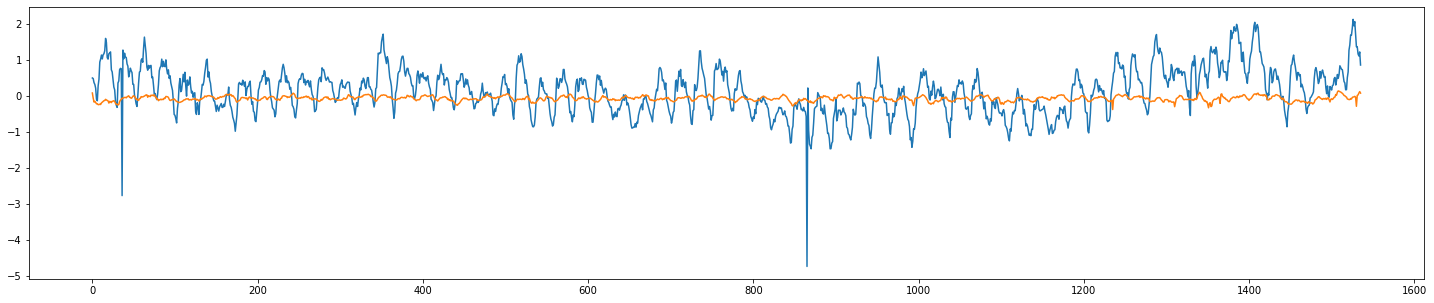

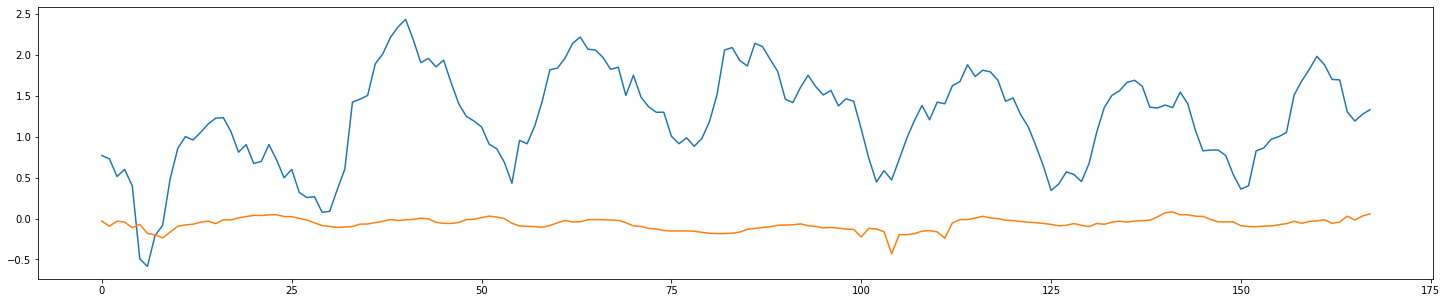

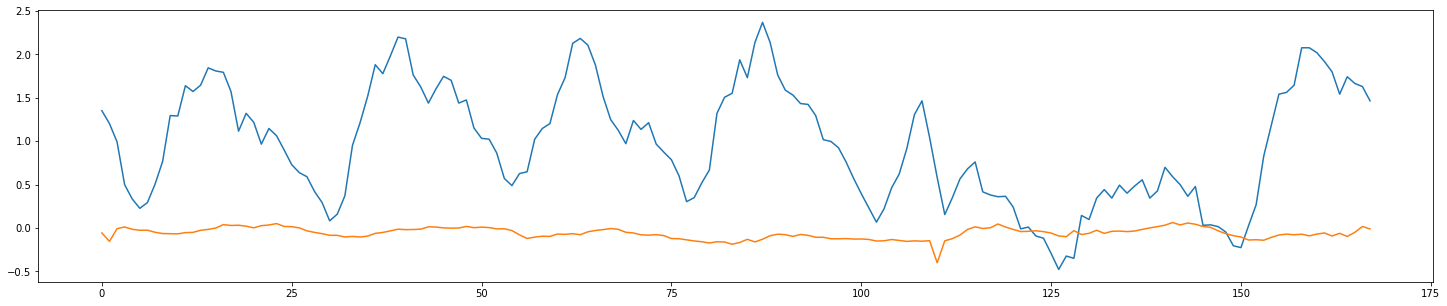

In [29]:
idx = 0

y_train_true, y_train_pred = mk_true_pred(
    train_ds,
    train.query('num==0').shape[0]-CONFIGS['window_size']-CONFIGS['target_length']+1
)
visualize(y_train_true, y_train_pred, idx)

y_valid_true, y_valid_pred = mk_true_pred(
    valid_ds,
    valid.query('num==0').shape[0]-CONFIGS['window_size']-CONFIGS['target_length']+1
)
visualize(y_valid_true, y_valid_pred, idx)

y_test_true, y_test_pred = mk_true_pred(
    test_ds,
    test.query('num==0').shape[0]-CONFIGS['window_size']-CONFIGS['target_length']+1
)
visualize(y_test_true, y_test_pred, idx)

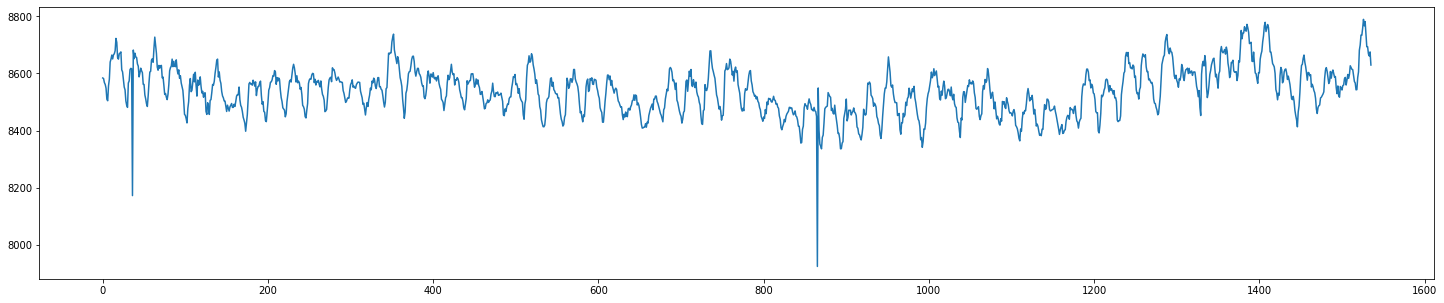

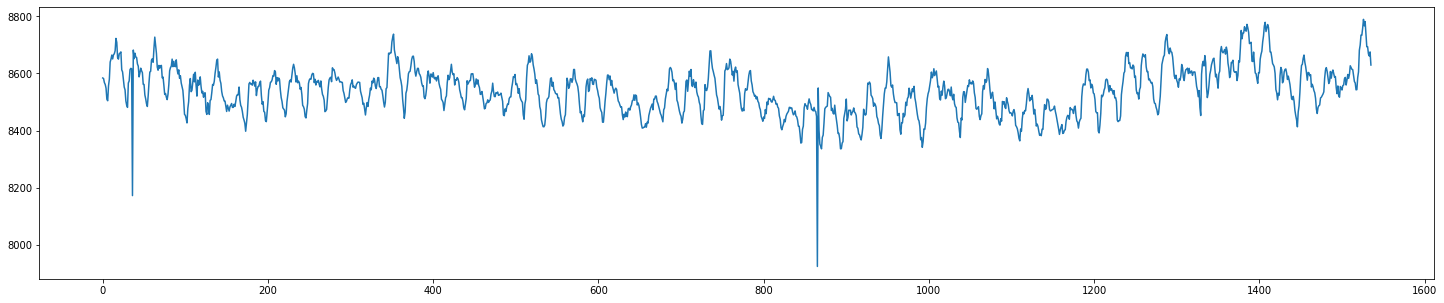

In [30]:
tmp = train.query(f'num == {idx}')
target_tmp = (
    tmp['target'] * \
    tmp['std_to_inverse'] + \
    tmp['mean_to_inverse']
)[168:].reset_index(drop=True)

plt.figure(figsize=(25, 5))
plt.plot(target_tmp)
plt.show()

tmp = data.query(f'num == {idx}').reset_index(drop=True)
target_tmp = tmp['target'][168:-168*2].reset_index(drop=True)

plt.figure(figsize=(25, 5))
plt.plot(target_tmp)
plt.show()

In [33]:
def mk_true_pred(ds, seq_len):
    
    y_true = ds.unbatch().batch(seq_len)
    y_true = y_true.map(lambda x, y: tf.reshape(y, (-1, CONFIGS['target_length']))).as_numpy_iterator()
    y_true = np.array(list(y_true))

    y_pred = best_model.predict(ds)
    mean = y_pred[:, -2]
    std = y_pred[:, -1]
    y_pred = y_pred[:, :-2]

    f_shape = list(y_true.shape)

    y_pred = y_pred.reshape(f_shape)
    f_shape[-1] = 1
    mean = mean.reshape(f_shape)
    std = std.reshape(f_shape)

    y_true = y_true*std+mean
    y_pred = y_pred*std+mean

    return y_true, y_pred

In [34]:
y_true, y_pred = mk_true_pred(train_ds, 1534)

In [35]:
iter(train_ds.unbatch().batch(1534)).next()

((<tf.Tensor: shape=(1534, 1), dtype=int16, numpy=
  array([[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]], dtype=int16)>,
  <tf.Tensor: shape=(1534, 5), dtype=float32, numpy=
  array([[-0.78192174,  3.4315276 , -0.7918083 , -0.6576589 , -0.9102245 ],
         [-0.78192174,  3.4315276 , -0.7918083 , -0.6576589 , -0.9102245 ],
         [-0.78192174,  3.4315276 , -0.7918083 , -0.6576589 , -0.9102245 ],
         ...,
         [-0.78192174,  3.4315276 , -0.7918083 , -0.6576589 , -0.9102245 ],
         [-0.78192174,  3.4315276 , -0.7918083 , -0.6576589 , -0.9102245 ],
         [-0.78192174,  3.4315276 , -0.7918083 , -0.6576589 , -0.9102245 ]],
        dtype=float32)>,
  <tf.Tensor: shape=(1534, 10), dtype=float32, numpy=
  array([[-1.3154473 ,  0.19913284,  0.63536817, ...,  1.        ,
           0.        ,  0.        ],
         [-1.3461448 , -1.1256552 ,  0.63536817, ...,  1.        ,
           0.        ,  0.        ],
         [-1.3461448 , -